In [1]:
#Diffusion Sigma analysis
#Get final R position of a drift line (no diffusion)
#   - Open condened file
#   - Fit a gaussian to the histogram - extract mu and sigma
#   - Compare Gaussian to mu and sigma to final drift position and sqrt(4*D_T*DriftTime)
#   - Repeat for 9 positions (0,2) --> (72.5, 2)

In [2]:
#INITIALIZION
#Kernel PyROOT
import os
#os.sys.path.append('/usr/common/software/rootpy')
#os.sys.path.insert(0,'/usr/common/software/uproot')
#import root_numpy
#import root_numpy as root_np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('GTK3Agg')
import ROOT
import pandas as pd

import sys
from matplotlib.colors import LogNorm
import pylab

import glob
import uproot

import scipy
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.stats as stats

%pylab inline
#pylab.rcParams['figure.figsize'] = (10.0, 8.0)

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

print("Starting notebook....")

Welcome to JupyROOT 6.16/00
Populating the interactive namespace from numpy and matplotlib
Starting notebook....


/cvmfs/sft.cern.ch/lcg/views/LCG_95/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
from scipy.stats import norm

#For individual subdir get all files
def Get_All_files(d):
    file_list=[]
    for file in os.listdir(d):
        if file.endswith(".txt"):
            print(os.path.join(file))
            file_list.append(d+os.path.join(file))
    return sorted(file_list)

#Fill lists for single file
def Get_R_DT_lists(filename):
    r_list = []
    DT_list = []

    f = open(filename, 'r')
    lines = f.readlines()
    #print len(lines)

    for line in lines:
        if line.startswith("#"):
            continue
        else:
            a=line.split("\t")
            if len(a)==2:
                r_list.append(float(a[0]))
                DT_list.append(float(a[1]))
    
    return r_list, DT_list

#Get the i^th entry from diffusion/drfift line file
def Get_i_line_from_file(filename, i):
    file = open(filename, 'r')
    lines = file.readlines()
    a = lines[i].split('\t\t')
    DriftTime_us= float(a[2])
    r_cm = float(a[3])
    z_cm = float(a[4])
    return r_cm, z_cm, DriftTime_us

#Choose last element
def Get_Final_Element_index(r_origin):
    if pow( float(r_origin) - 52.5,2) < 0.001 or pow( float(r_origin) - 61.25,2) < 0.001 or pow( float(r_origin) - 43.75,2) < 0.001:
        j=-5
    elif pow( float(r_origin) - 70,2) < 0.001 or pow( float(r_origin) - 35,2) < 0.001 or pow( float(r_origin) - 26.25,2) < 0.001:
        j=-3
    else:
        j=-1
    return j

#Gaussian Function
def Gaussian(x, mu, sigma):
    A= 1/(sigma*pow(2*pi,.5))
    B= -.5*pow((x-mu)/sigma, 2.)
    return A*np.exp(B)
vGaussian = np.vectorize(Gaussian)




print "\n\t...Done!"


	...Done!


In [4]:
#Main function

def Get_Histogram(directory):
    r_list, DT_list = Get_R_DT_lists(directory)
    r_origin = directory.split("r")[-1].split("txt")[0]
    r_origin = r_origin[:-1]
    
    num_bins=100
    #At r=0 we need to spread the data into negative R region to fix the fit
    if float(r_origin) ==0:
        num_bins=200
        new_r_list = []
        new_DT_list = []
        turn = 0.001
        for i in range(0, len(DT_list)):
            new_r_list.append(r_list[i])
            new_DT_list.append(DT_list[i])
            new_DT_list.append(DT_list[i])
            if r_list[i] > turn:
                new_r_list.append(r_list[i]*-1.)
            else:
                new_r_list.append(r_list[i])
        r_list= new_r_list
        DT_list= new_DT_list
    
    print "r_origin = "+str(r_origin)+"\t len(r_list) = "+str(len(r_list))
    j=Get_Final_Element_index(r_origin)
    print "j: "+str(j)
    #For a single diffusion analysis get a histogram of final positions
    #if float(r_origin) < 1:
    #    filename = d_3+"SingleDriftLineCalc_.5cm_r0"+str(r_origin)+"cm_z02.0cm_0504.txt"
    #else:
    filename = d_3+"SingleDriftLineCalc_.5cm_r"+str(r_origin)+"cm_z02.0cm_0504.txt"
    drift_r,drift_z,drift_t=Get_i_line_from_file(filename,j)

    print "Driftline: r = "+str(drift_r)+"\t z = "+str(drift_z)+"\t t = "+str(drift_t)
    
    #Make histogram
    hist, n_bins = np.histogram(r_list, bins=num_bins)
    h_center = (n_bins[:-1] + n_bins[1:]) / 2
    hist = hist.astype(np.float) / sum(hist.astype(np.float))
    
    if float(r_origin) ==0:
        #print "MONEY!"
        for i in range(0, len(hist)):
            if h_center[i] > 0.0 and h_center[i]< 0.01:
                hist[i] = hist[i]*1.35
            elif h_center[i] > 0.4 and h_center[i]< 0.6:
                hist[i] = hist[i]*.6

    
    #Get Gaussian fit for hist and a predicted Gaussian from the line without diffusion
    fit_mu, fit_sigma = norm.fit(r_list)

    GausFit_x = np.arange(min(h_center-fit_sigma), max(h_center+fit_sigma), .01)
    GausFit_y = vGaussian(GausFit_x, fit_mu, fit_sigma)

    n=3.
    #GausPred_x = np.arange(drift_r - n*pow(4*D_T*drift_t,.5), drift_r + n*pow(4*D_T*drift_t,.5), .01)
    #GausPred_y = vGaussian(GausPred_x, drift_r, pow(4*D_T*drift_t,.5))
    GausPred_x = np.arange(drift_r - n*pow(2*D_T*drift_t,.5), drift_r + n*pow(2*D_T*drift_t,.5), .01)
    GausPred_y = vGaussian(GausPred_x, drift_r, pow(2*D_T*drift_t,.5))

    #Normalise Gaussian fits
    GausFitNorm = max(hist)/max(GausFit_y)
    GausPredNorm= max(hist)/max(GausPred_y)

    print "\n\t...Gaussian fit generated!"

    #Show histogram
    if float(r_origin) < 1:
        xlo_lim= 0
        xhi_lim= max(GausPred_x)
    else:
        xlo_lim= min(GausPred_x)
        xhi_lim= max(GausPred_x)
        
    w = (n_bins[1] - n_bins[0]) #*.7
        
    return h_center, hist, w, GausFit_x, GausFit_y, GausFitNorm, GausPred_x, GausPred_y, GausPredNorm, xlo_lim, xhi_lim, drift_r, drift_t, fit_mu, fit_sigma



print "\n\t...Done!"


	...Done!


In [5]:
#Constants
D_T = 55e-6 #cm^2/us

print "\n\t...Done!"


	...Done!


In [6]:
#Get list of drift lines
#d="/data/rossiter/lz/EDM_DiffusionAnalysis_2005_2/Condensed_2/"
d="/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/"
d_3 = "/home/rossiter/LZ_EDM_200501/DiffusionAnalysis_0505/"

file_list = Get_All_files(d)

print file_list

#print len(file_list)
#print file_list[0]

r17.5.txt
r26.25.txt
r35.txt
r52.5.txt
r61.25.txt
r70.txt
r00.txt
r43.75.txt
r08.75.txt
['/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r00.txt', '/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r08.75.txt', '/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r17.5.txt', '/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r26.25.txt', '/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r35.txt', '/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r43.75.txt', '/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r52.5.txt', '/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r61.25.txt', '/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r70.txt']


/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r00.txt
r_origin = 00	 len(r_list) = 2000
j: -1
Driftline: r = 0.0	 z = 146.1	 t = 789.953

	...Gaussian fit generated!
fit_mu = -0.00016729212000000105
drift_r = 0.0


(-1.5, 1.5)

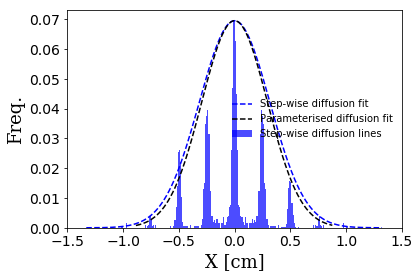

In [7]:

ii=0
print file_list[ii]
a = Get_Histogram(file_list[ii])
h_center = a[0]
hist = a[1]
w = a[2]
GausFit_x = a[3] 
GausFit_y = a[4]
GausFitNorm = a[5]
GausPred_x = a[6]
GausPred_y = a[7]
GausPredNorm = a[8]
xlo_lim = a[9]
xhi_lim = a[10]
drift_r=a[11]
drift_t=a[12]
fit_mu=a[13]
fit_sigma=a[14]

#plot histogram
plt.bar(h_center, hist, align='center', color='blue', alpha=.7, width=w, label='Step-wise diffusion lines')
#plt.plot(drift_r, max(hist), marker="x", color='k', markersize=22, label='Drift line')

plt.plot(GausFit_x, GausFit_y*GausFitNorm, '--b', label="Step-wise diffusion fit")
plt.plot(GausPred_x, GausPred_y*GausPredNorm, '--k', label="Parameterised diffusion fit")

plt.xlabel('X [cm]',fontsize=18,family='serif');
plt.ylabel('Freq.',fontsize=18,family='serif');
plt.legend(frameon=False, loc='best');
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.xlim(xlo_lim, xhi_lim)

print "fit_mu = "+str(fit_mu)
print "drift_r = "+str(drift_r)
plt.xlim(-1.5, 1.5)

(0, 0.8756621290479543)

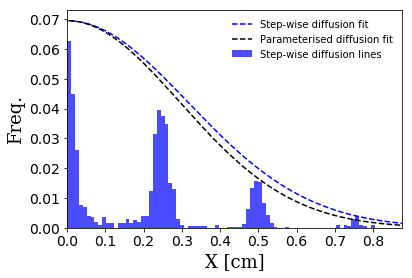

In [8]:
#plot histogram
plt.bar(h_center, hist, align='center', color='blue', alpha=.7, width=w, label='Step-wise diffusion lines')
#plt.plot(drift_r, max(hist), marker="x", color='k', markersize=22, label='Drift line')

plt.plot(GausFit_x, GausFit_y*GausFitNorm, '--b', label="Step-wise diffusion fit")
plt.plot(GausPred_x, GausPred_y*GausPredNorm, '--k', label="Parameterised diffusion fit")

plt.xlabel('X [cm]',fontsize=18,family='serif');
plt.ylabel('Freq.',fontsize=18,family='serif');
plt.legend(frameon=False, loc='best');
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(xlo_lim, xhi_lim)

In [9]:
#Get all files
#
h_center_list=[]
hist_list=[] 
w_list=[]
GausFit_x_list=[] 
GausFit_y_list=[] 
GausFitNorm_list=[]
GausPred_x_list=[]
GausPred_y_list=[]
GausPredNorm_list=[]
xlo_lim_list=[]
xhi_lim_list=[]
drift_r_list=[]
drift_t_list=[]
fit_mu_list=[]
fit_sigma_list=[]



#ii=5
for ii in range(0, len(file_list)):
    print file_list[ii]
    a = Get_Histogram(file_list[ii])

    h_center_list.append(a[0])
    hist_list.append(a[1])
    w_list.append(a[2])
    GausFit_x_list.append(a[3]) 
    GausFit_y_list.append(a[4])
    GausFitNorm_list.append(a[5])
    GausPred_x_list.append(a[6])
    GausPred_y_list.append(a[7])
    GausPredNorm_list.append(a[8])
    xlo_lim_list.append(a[9])
    xhi_lim_list.append(a[10])
    drift_r_list.append(a[11])
    drift_t_list.append(a[12])
    fit_mu_list.append(a[13])
    fit_sigma_list.append(a[14])



print "\n\t...Done!"

/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r00.txt
r_origin = 00	 len(r_list) = 2000
j: -1
Driftline: r = 0.0	 z = 146.1	 t = 789.953

	...Gaussian fit generated!
/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r08.75.txt
r_origin = 08.75	 len(r_list) = 1000
j: -1
Driftline: r = 8.73129	 z = 146.1	 t = 789.675

	...Gaussian fit generated!
/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r17.5.txt
r_origin = 17.5	 len(r_list) = 1000
j: -1
Driftline: r = 17.4539	 z = 146.1	 t = 789.694

	...Gaussian fit generated!
/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r26.25.txt
r_origin = 26.25	 len(r_list) = 1000
j: -3
Driftline: r = 26.2718	 z = 145.5	 t = 785.102

	...Gaussian fit generated!
/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r35.txt
r_origin = 35	 len(r_list) = 1000
j: -3
Driftline: r = 35.0296	 z = 145.5	 t = 785.101

	...Gaussian fit generated!
/data/rossiter/lz/EDM_DiffusionAnalysis_2007/Condensed/r43.75.txt
r_origin = 43.75	 len(r_lis

(0, 0.15)

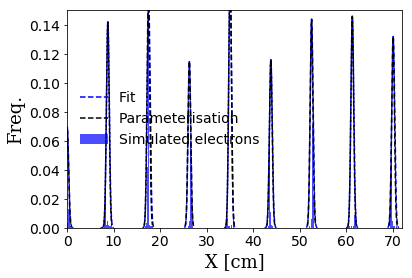

In [10]:
#Plot all results on one axis
#i=1
figure(1)
for i in range(0, len(h_center_list)):
    if i==0:
        plt.bar(h_center_list[i], hist_list[i], align='center', color='blue', alpha=.7, width=w_list[i], label="Simulated electrons")
        plt.plot(GausFit_x_list[i], GausFit_y_list[i]*GausFitNorm_list[i], '--b', label="Fit")
        plt.plot(GausPred_x_list[i], GausPred_y_list[i]*GausPredNorm_list[i], '--k', label="Parameterisation")
    else:
        plt.bar(h_center_list[i], hist_list[i], align='center', color='blue', alpha=.7, width=w_list[i])
        plt.plot(GausFit_x_list[i], GausFit_y_list[i]*GausFitNorm_list[i], '--b')
        plt.plot(GausPred_x_list[i], GausPred_y_list[i]*GausPredNorm_list[i], '--k')



plt.xlabel('X [cm]',fontsize=18,family='serif');
plt.ylabel('Freq.',fontsize=18,family='serif');
plt.legend(frameon=False, loc='best', fontsize=14);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, 72)
plt.ylim(0, 0.15)

np.mean(fit_sigma_list) = 0.30890159559157143
np.mean(Parameterisation) = 0.2941577751486809

fit: max - min = 0.03226375439361423
para: max - min = 0.0009534745693110525

m = 6.16841600270081e-05
c = 0.3067411751223599

	...Done!


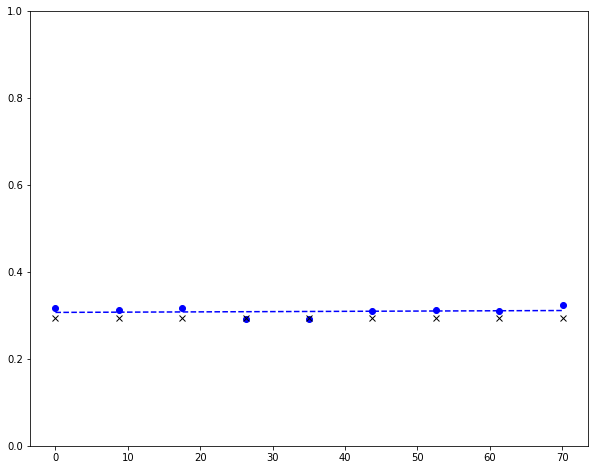

In [11]:
#R vs sigma
from scipy import stats

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

#def linfunc(x, m, c):
#    return (m*x)+c
#vlinfunc = np.vectorize(linfunc)

m, c, r_value, p_value, std_err = stats.linregress(drift_r_list, fit_sigma_list)

xdata = np.arange(min(drift_r_list), max(drift_r_list), 10)
ydata = (m*xdata) + c

figure(1)
plt.plot(drift_r_list, fit_sigma_list, 'ob')
plt.plot( xdata, ydata, '--b' )
#plt.plot(drift_r_list, pow(4*D_T*np.asarray(drift_t_list), .5), 'xk')
plt.plot(drift_r_list, pow(2*D_T*np.asarray(drift_t_list), .5), 'xk')
plt.ylim(0,1)

print "np.mean(fit_sigma_list) = "+str(np.mean(fit_sigma_list))
#print "np.mean(Parameterisation) = "+str(np.mean(pow(4*D_T*np.asarray(drift_t_list),.5)))
print "np.mean(Parameterisation) = "+str(np.mean(pow(2*D_T*np.asarray(drift_t_list),.5)))

print "\nfit: max - min = "+str( max(fit_sigma_list) - min(fit_sigma_list) )
#print "para: max - min = "+str( max(pow(4*D_T*np.asarray(drift_t_list),.5)) - min(pow(4*D_T*np.asarray(drift_t_list),.5)) )
print "para: max - min = "+str( max(pow(2*D_T*np.asarray(drift_t_list),.5)) - min(pow(2*D_T*np.asarray(drift_t_list),.5)) )


print "\nm = "+str(m)
print "c = "+str(c)

print "\n\t...Done!"

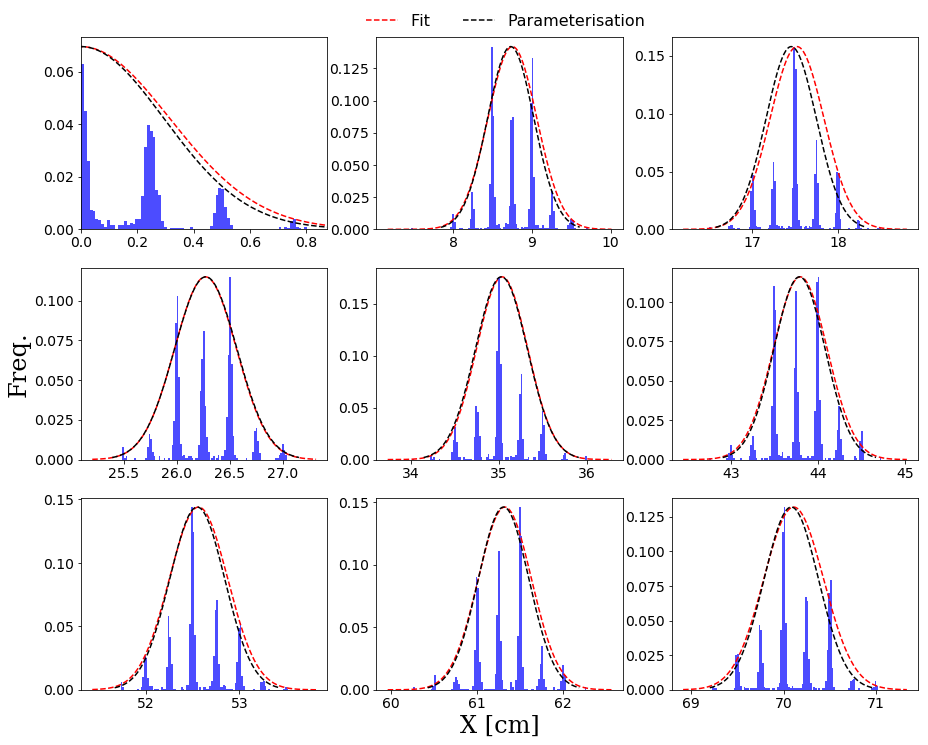

In [43]:
#3 x 3 plot

size1=14
size2=16
size3=24

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)


label_x = 1
label_y = 4
arrow_x = .8
arrow_y = .06

arrow_properties = dict(
    facecolor="black", width=0.5,
    headwidth=4, shrink=0.1)

fig, ax = plt.subplots(nrows=3, ncols=3)
i=0
ii=0
for row in ax:
    for col in row:
        if i==0: #Halve bins which aren't on R=0 for first plot
            col.bar(h_center_list[i], hist_list[i], align='center', color='blue', alpha=.7, width=w_list[i])
            col.plot(GausFit_x_list[i], GausFit_y_list[i]*GausFitNorm_list[i], '--r')
            col.plot(GausPred_x_list[i], GausPred_y_list[i]*GausPredNorm_list[i], '--k')
            #col.legend(frameon=False, bbox_to_anchor=(1.1, 1.05), fontsize=size2)
        elif i==5:
            col.bar(h_center_list[i], hist_list[i], align='center', color='blue', alpha=.7, width=w_list[i])
            col.plot(GausFit_x_list[i], GausFit_y_list[i]*GausFitNorm_list[i], '--r', label='Fit')
            col.plot(GausPred_x_list[i], GausPred_y_list[i]*GausPredNorm_list[i], '--k', label='Parameterisation')
            col.legend(frameon=False, bbox_to_anchor=(-.05, 2.4), ncol=2, fontsize=size2)
        else:
            col.bar(h_center_list[i], hist_list[i], align='center', color='blue', alpha=.7, width=w_list[i])
            col.plot(GausFit_x_list[i], GausFit_y_list[i]*GausFitNorm_list[i], '--r')
            col.plot(GausPred_x_list[i], GausPred_y_list[i]*GausPredNorm_list[i], '--k')
        col.tick_params(axis="x", labelsize=size1)
        col.tick_params(axis="y", labelsize=size1)
        i+=1
        if i==1:
            col.set_xlim([xlo_lim_list[i-1],xhi_lim_list[i-1]])
        elif i==4:
            col.set_ylabel('Freq.',fontsize=size3,family='serif');
        elif i==8:
            col.set_xlabel('X [cm]',fontsize=size3,family='serif');
    ii+=1
          
#plt.legend(frameon=False, loc='best');
plt.show()



#%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
#run KS test between both gaussians in each plot

#i=0
pval_list = []
for i in range(0, len(GausFit_y_list)):
    pval = stats.ks_2samp(GausFit_y_list[i], GausPred_y_list[i])[1]
    pval_list.append(pval_list)
    print str(i)+"\t"+str(pval)


print "\n"
print np.mean(pval_list)
print np.std(pval_list)

In [ ]:
print len(fit_mu_list)
print len(drift_r_list)

In [ ]:
print fit_mu_list

In [ ]:

dR_list = []
dSIG_list = []

for i in range(0, len(fit_mu_list)):
    print fit_mu_list[i] - drift_r_list[i]
    dR_list.append(fit_mu_list[i] - drift_r_list[i])
    #dSIG_list.append( fit_sigma_list[i] - pow(4*D_T*drift_t_list[i],.5) )
    dSIG_list.append( fit_sigma_list[i] - pow(2*D_T*drift_t_list[i],.5) )
    
#figure(1)
#plt.plot(drift_r_list, dSIG_list, '.k')

print "\n\t np.mean(dR_list) = "+str(np.mean(dR_list))
print "\n\t np.mean(dSIG_list) = "+str(np.mean(dSIG_list))

# - Look at lines from R = 0 to 1.5

In [ ]:
#Get list of drift lines
d="/data/rossiter/lz/EDM_DiffusionAnalysis_2005_2/Condensed_3/"

file_list = Get_All_files(d)

print file_list

#print len(file_list)
#print file_list[0]

In [ ]:
#Check one file
ii=0
print file_list[ii]
a = Get_Histogram(file_list[ii])
h_center = a[0]
hist = a[1]
w = a[2]
GausFit_x = a[3] 
GausFit_y = a[4]
GausFitNorm = a[5]
GausPred_x = a[6]
GausPred_y = a[7]
GausPredNorm = a[8]
xlo_lim = a[9]
xhi_lim = a[10]
drift_r=a[11]
drift_t=a[12]
fit_mu=a[13]
fit_sigma=a[14]

#plot histogram
plt.bar(h_center, hist, align='center', color='blue', alpha=.7, width=w, label='Step-wise diffusion lines')
#plt.plot(drift_r, max(hist), marker="x", color='k', markersize=22, label='Drift line')

plt.plot(GausFit_x, GausFit_y*GausFitNorm, '--b', label="Step-wise diffusion fit")
plt.plot(GausPred_x, GausPred_y*GausPredNorm, '--k', label="Parameterised diffusion fit")

plt.xlabel('X [cm]',fontsize=18,family='serif');
plt.ylabel('Freq.',fontsize=18,family='serif');
plt.legend(frameon=False, loc='best');
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(xlo_lim, xhi_lim)

print "fit_mu = "+str(fit_mu)
print "drift_r = "+str(drift_r)

In [ ]:
#Get all files
#
h_center_list=[]
hist_list=[] 
w_list=[]
GausFit_x_list=[] 
GausFit_y_list=[] 
GausFitNorm_list=[]
GausPred_x_list=[]
GausPred_y_list=[]
GausPredNorm_list=[]
xlo_lim_list=[]
xhi_lim_list=[]
drift_r_list=[]
drift_t_list=[]
fit_mu_list=[]
fit_sigma_list=[]



#ii=5
for ii in range(0, len(file_list)):
    print file_list[ii]
    a = Get_Histogram(file_list[ii])

    h_center_list.append(a[0])
    hist_list.append(a[1])
    w_list.append(a[2])
    GausFit_x_list.append(a[3]) 
    GausFit_y_list.append(a[4])
    GausFitNorm_list.append(a[5])
    GausPred_x_list.append(a[6])
    GausPred_y_list.append(a[7])
    GausPredNorm_list.append(a[8])
    xlo_lim_list.append(a[9])
    xhi_lim_list.append(a[10])
    drift_r_list.append(a[11])
    drift_t_list.append(a[12])
    fit_mu_list.append(a[13])
    fit_sigma_list.append(a[14])



print "\n\t...Done!"

In [ ]:
#Plot all results on one axis
#i=1
figure(1)
for i in range(0, len(h_center_list)):
    if i==0:
        plt.bar(h_center_list[i], hist_list[i], align='center', color='blue', alpha=.7, width=w_list[i], label="Simulated electrons")
        plt.plot(GausFit_x_list[i], GausFit_y_list[i]*GausFitNorm_list[i], '--b', label="Fit")
        plt.plot(GausPred_x_list[i], GausPred_y_list[i]*GausPredNorm_list[i], '--k', label="Parameterisation")
    else:
        plt.bar(h_center_list[i], hist_list[i], align='center', color='blue', alpha=.7, width=w_list[i])
        plt.plot(GausFit_x_list[i], GausFit_y_list[i]*GausFitNorm_list[i], '--b')
        plt.plot(GausPred_x_list[i], GausPred_y_list[i]*GausPredNorm_list[i], '--k')



plt.xlabel('X [cm]',fontsize=18,family='serif');
plt.ylabel('Freq.',fontsize=18,family='serif');
plt.legend(frameon=False, loc='best', fontsize=14);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, 2)
plt.ylim(0, 0.15)

In [ ]:
"""#3 x 3 plot


#%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)

fig, ax = plt.subplots(nrows=3, ncols=3)



i=0
for row in ax:
    for col in row:
        col.bar(h_center_list[i], hist_list[i], align='center', color='blue', alpha=.7, width=w_list[i])
        col.plot(GausFit_x_list[i], GausFit_y_list[i]*GausFitNorm_list[i], '--b')
        col.plot(GausPred_x_list[i], GausPred_y_list[i]*GausPredNorm_list[i], '--k')
        col.tick_params(axis="x", labelsize=14)
        col.tick_params(axis="y", labelsize=14)
        col.set_xlim([xlo_lim_list[i],xhi_lim_list[i]])
        i+=1            
        if i==4:
            col.set_ylabel('Freq.',fontsize=18,family='serif');
        elif i==8:
            col.set_xlabel('R [cm]',fontsize=18,family='serif');


            
#plt.legend(frameon=False, loc='best');


plt.show()



%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)"""

In [ ]:
#Look at change in dR and dSIG
plot_drift_r_list=[]
dR_list = []
dSIG_list = []

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

for i in range(0, len(fit_mu_list)):
    #if drift_r_list[i] < 1.1:
    plot_drift_r_list.append(drift_r_list[i])
    #print str(fit_mu_list[i] - drift_r_list[i])+"\t"+str(pow(pow(fit_sigma_list[i] - pow(4*D_T*drift_t_list[i],.5),2),.5))
    print str(fit_mu_list[i] - drift_r_list[i])+"\t"+str(pow(pow(fit_sigma_list[i] - pow(2*D_T*drift_t_list[i],.5),2),.5))
    dR_list.append(fit_mu_list[i] - drift_r_list[i])
    #dSIG_list.append( pow(pow(fit_sigma_list[i] - pow(4*D_T*drift_t_list[i],.5),2),.5) )
    dSIG_list.append( pow(pow(fit_sigma_list[i] - pow(2*D_T*drift_t_list[i],.5),2),.5) )

print "\n\t np.mean(dR_list) = "+str(np.mean(dR_list))
print "\n\t np.mean(dSIG_list) = "+str(np.mean(dSIG_list))

In [ ]:
def expfunc(x, a, b, c):
    return a * np.exp(-b * x) + c
vexpfunc = np.vectorize(expfunc)

def linfunc(x, a, b):
    return a*x + b
vlinfunc = np.vectorize(linfunc)

popt_mu, pcov_mu = curve_fit(expfunc, plot_drift_r_list, dR_list)
popt_sig, pcov_sig = curve_fit(expfunc, plot_drift_r_list, dSIG_list)

print popt_mu[0]
print popt_mu[1]
print popt_mu[2]

x_data = np.arange(0,1.5, .01)
y_data_mu = vexpfunc(x_data, popt_mu[0], popt_mu[1], popt_mu[2])
y_data_sig = vexpfunc(x_data, popt_sig[0], popt_sig[1], popt_sig[2])

In [ ]:
figure(1)
plt.plot(plot_drift_r_list, dR_list, '.k')
plt.plot(x_data, y_data_mu, '-r')
plt.xlabel('X [cm]',fontsize=18,family='serif');
plt.ylabel('$\Delta\mu$',fontsize=18,family='serif');



figure(2)
plt.plot(plot_drift_r_list, dSIG_list, '.b')
plt.plot(x_data, y_data_sig, '-r')
plt.xlabel('X [cm]',fontsize=18,family='serif');
plt.ylabel('$\Delta\sigma$',fontsize=18,family='serif');

